Tests for parsing the MusicXML files to training data

In [1]:
import numpy as np
import music21 as m21
from IPython.display import Image
from copy import deepcopy
from fractions import Fraction

In [2]:
allBach = m21.corpus.search('bach')


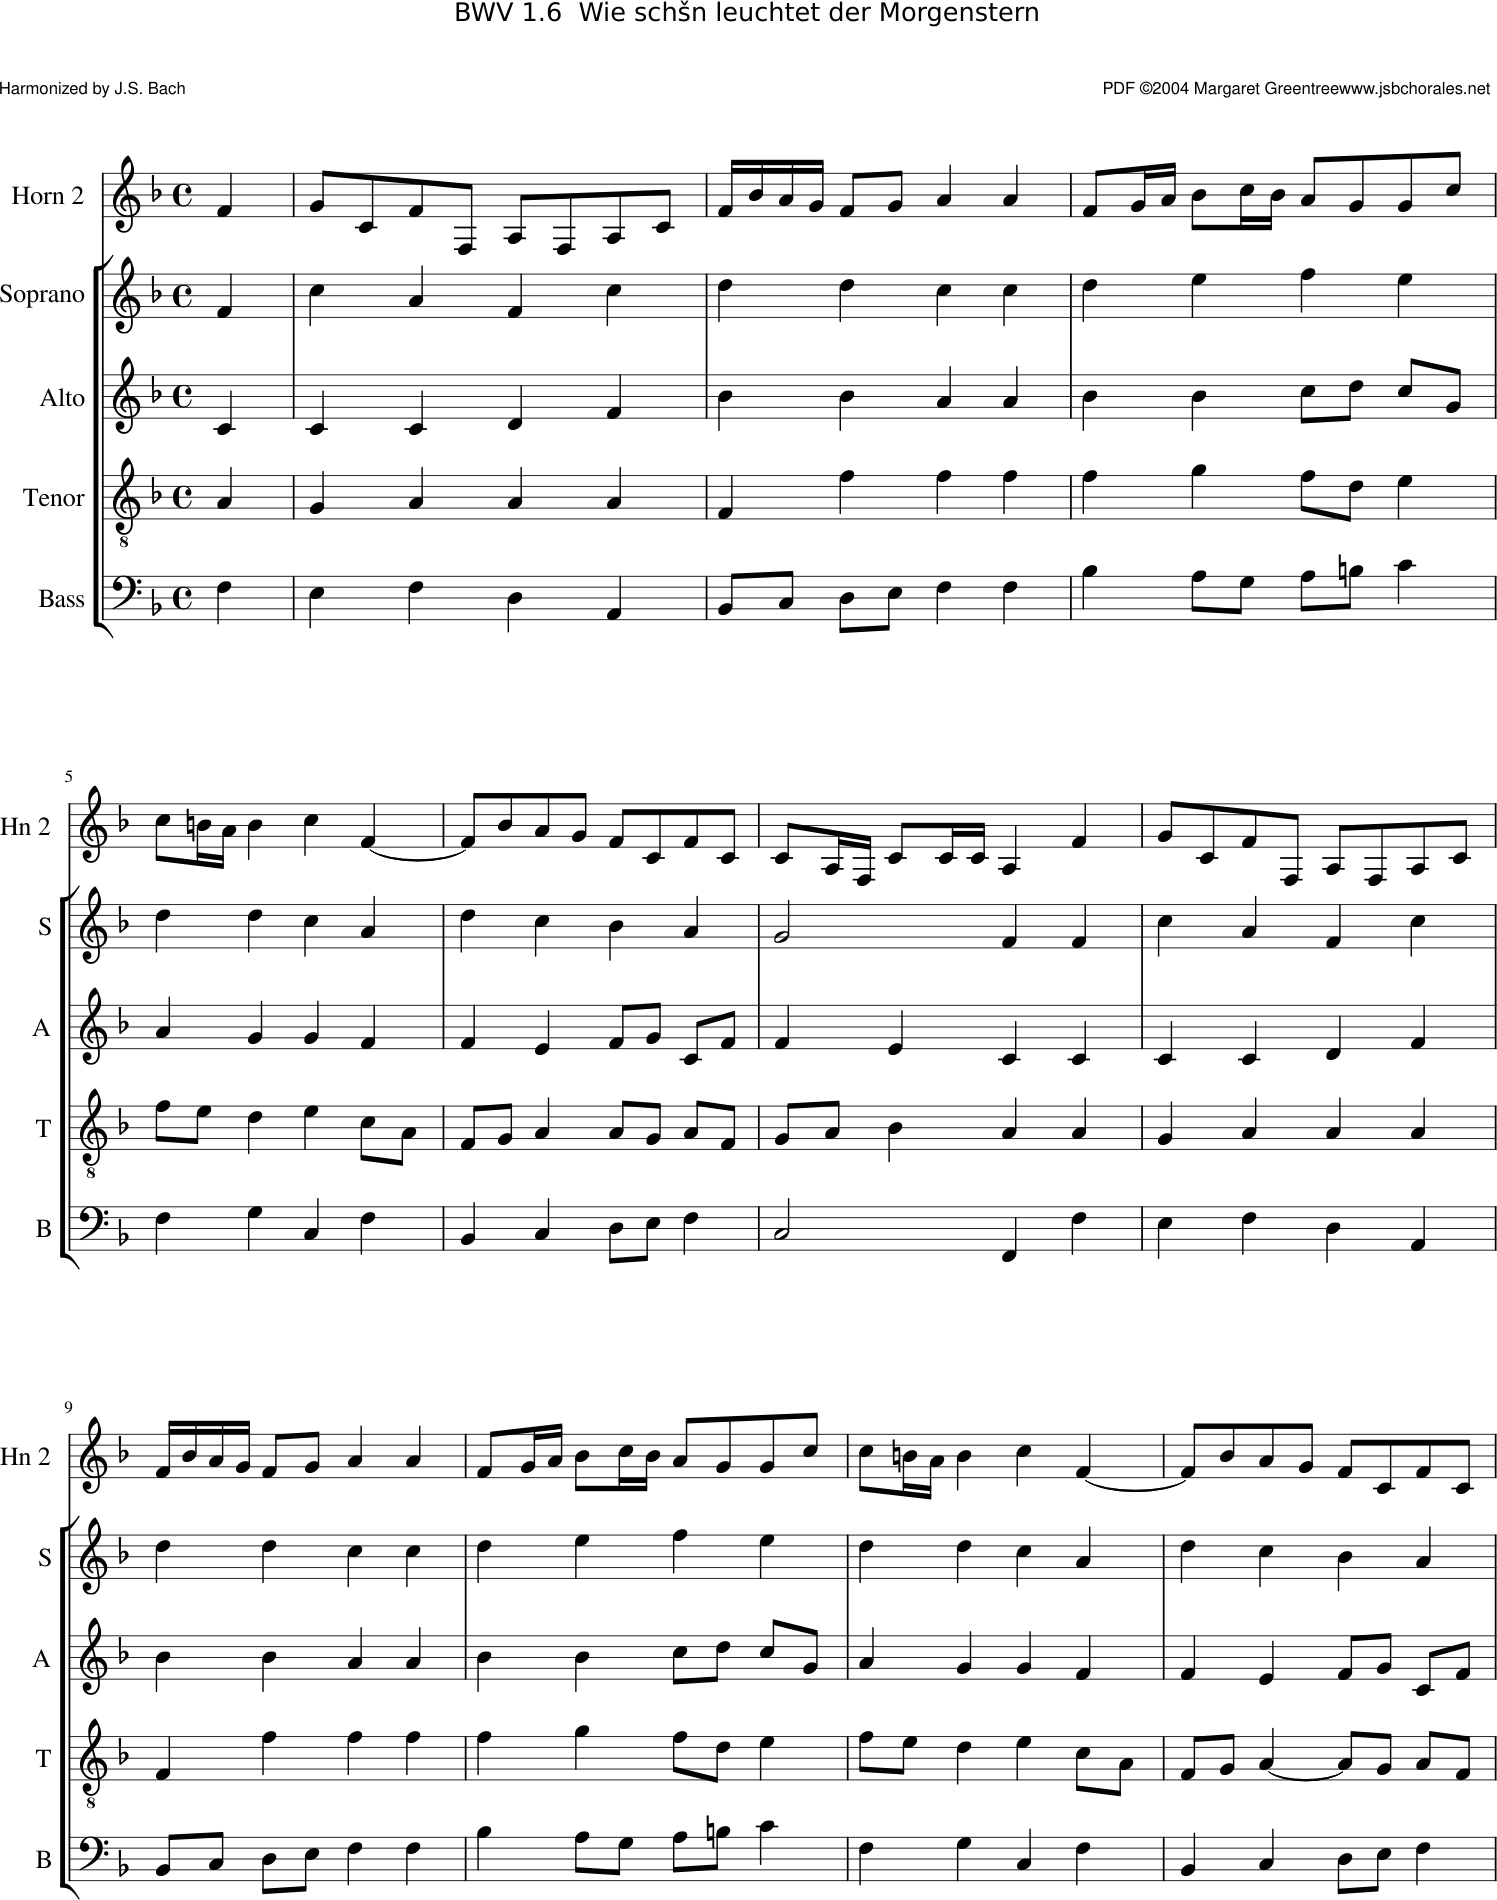

In [3]:
s1 = allBach[1].parse()
s1.show()

In [25]:
s1.show('midi')

In [119]:
def clean_score(score, verbose=False):
    '''
    - Transposes to key of C
    - Sets simultaneous notes to a chord object (chordifies parts, any problems?)
    - Pads short bars with rests
    - Fixes bars that are too long (assumes notes in correct offset)
    - Strips unnecessary elements
    - etc
    '''
    
    # what is wanted in each part
    allowed = [
        m21.instrument.Instrument,
        m21.stream.Measure,
        m21.meter.TimeSignature,
        m21.clef.Clef,
        m21.key.KeySignature,
        m21.note.Note,
        m21.note.Rest,
        m21.chord.Chord
    ]
    
    if verbose: print('Cleaning...')
        
    key = score.analyze('key')
    key_diff = m21.interval.Interval(key.tonic, m21.pitch.Pitch('C'))
    if verbose: print('Found Key ({})...'.format(key))
    
    new_score = m21.stream.Score()
    
    for part in score.parts:
        if verbose: print(part, '----------')
        
        # check if percussive clef...
        if part.recurse().getElementsByClass(m21.clef.PercussionClef):
            if verbose: print('Percussion, skipping!')
            continue
        
        new_part = m21.stream.Part()
        
        # make sure there are measures...
        if len(part.getElementsByClass(m21.stream.Measure)) == 0:
            if verbose: print('making measures...')
            part.makeMeasures(inPlace=True)
        
        # clean each measure...
        for m in part.getElementsByClass(m21.stream.Measure):
            
            new_m = m21.stream.Measure(quarterLength=m.quarterLength)
            
            # strip to core elements...
            for element in m.flat.getElementsByClass(allowed):
                new_m.append(element)
            
            if len(new_m.notesAndRests) == len(new_m.getElementsByClass(m21.note.Rest)):
                if verbose: print('rest bar found')
                new_m = m21.stream.Measure(quarterLength=m.quarterLength)
                new_m.insert(0.0, m21.note.Rest(m.barDuration))
                new_part.append(new_m)
                continue
            
            if new_m.duration.quarterLength < new_m.barDuration.quarterLength:
                if verbose: print('padding ', m.number)
                
                if m.number < 2:
                    # need to pad out the left side with a rest...
                    shift = m.paddingLeft
                    r = m21.note.Rest(quarterLength=shift)
                    new_m.insertAndShift(0, r)
                    for element in new_m.elements:
                        if element not in new_m.notesAndRests:
                            element.offset = 0.0
                else:
                    # pad on the right...
                    r = m21.note.Rest(quarterLength=m.padding)
                    new_m.append(r)
            
            elif m.duration.quarterLength > m.barDuration.quarterLength:
                if verbose: print('measure {} too long...'.format(m.number))
                    
                pass
 
            new_part.append(new_m)
        
        new_part.makeMeasures(inPlace=True)
        new_part.makeNotation(inPlace=True)
        
        new_score.insert(part.offset, new_part.chordify())
    
    return new_score.transpose(key_diff)

In [125]:
def parse_note_data(part, ts=None, verbose=False):
    '''
    Returns data in form (beat_stength, duration, pitch_class, octave)
    where pitch_class is -1 for rests, and has (+) operator if part of chord
    '''
    data = []
    last_octave = 4
    
    def get_octave(pitch, lo):
        if pitch.octave:
            return pitch.octave
        else:
            return lo
    
    if not ts:
        ts = part.timeSignature
        if not ts:
            ts = m21.meter.TimeSignature('4/4')
    
    for m in part.getElementsByClass("Measure"):
        if m.timeSignature:
            ts = m.timeSignature
            
        for n in m.flat.notesAndRests:
            bs = ts.getAccentWeight(n.offset, permitMeterModulus=True)
            d = n.duration.quarterLength

            if n.tie:
                if n.tie.type != "start":
                    continue

            if isinstance(n, m21.note.Note):
                last_octave = get_octave(n.pitch, last_octave)
                data.append((bs, d, str(n.pitch.pitchClass), last_octave))
                
                if verbose: print(n.offset, n, data[-1])

            elif isinstance(n, m21.note.Rest):
                data.append((bs, d, '-1', last_octave))
                
                if verbose: print(n.offset, n, data[-1])

            elif isinstance(n, m21.chord.Chord):
                ps = n.pitches
                for p in ps[:-1]:
                    last_octave =  get_octave(p, last_octave)
                    data.append((bs, d, str(p.pitchClass) + '+', last_octave))
                    if verbose: print(n.offset, n, data[-1])
                
                last_octave = get_octave(ps[-1], last_octave)
                data.append((bs, d, str(ps[-1].pitchClass), last_octave))
                if verbose: print(n.offset, n, data[-1])

            else:
                if verbose: print('Something else encountered: ', n)

            
    return data

In [6]:
parse_note_data(s1.parts[0])

[(1.0, '5', 4),
 (0.25, '7', 4),
 (0.125, '0', 4),
 (0.5, '5', 4),
 (0.125, '5', 3),
 (0.25, '9', 3),
 (0.125, '5', 3),
 (1.0, '9', 3),
 (0.125, '0', 4),
 (0.25, '5', 4),
 (0.25, '10', 4),
 (0.125, '9', 4),
 (0.125, '7', 4),
 (0.5, '5', 4),
 (0.125, '7', 4),
 (0.25, '9', 4),
 (1.0, '9', 4),
 (0.25, '5', 4),
 (0.125, '7', 4),
 (0.125, '9', 4),
 (0.5, '10', 4),
 (0.125, '0', 5),
 (0.125, '10', 4),
 (0.25, '9', 4),
 (0.125, '7', 4),
 (1.0, '7', 4),
 (0.125, '0', 5),
 (0.25, '0', 5),
 (0.125, '11', 4),
 (0.125, '9', 4),
 (0.5, '11', 4),
 (0.25, '0', 5),
 (1.0, '5', 4),
 (0.125, '10', 4),
 (0.5, '9', 4),
 (0.125, '7', 4),
 (0.25, '5', 4),
 (0.125, '0', 4),
 (1.0, '5', 4),
 (0.125, '0', 4),
 (0.25, '0', 4),
 (0.125, '9', 3),
 (0.125, '5', 3),
 (0.5, '0', 4),
 (0.125, '0', 4),
 (0.125, '0', 4),
 (0.25, '9', 3),
 (1.0, '5', 4),
 (0.25, '7', 4),
 (0.125, '0', 4),
 (0.5, '5', 4),
 (0.125, '5', 3),
 (0.25, '9', 3),
 (0.125, '5', 3),
 (1.0, '9', 3),
 (0.125, '0', 4),
 (0.25, '5', 4),
 (0.25, '10',

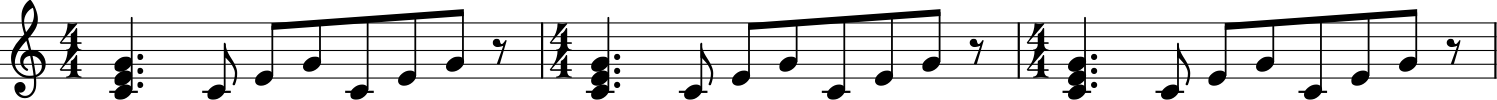

In [7]:
s = m21.stream.Score()
p1 = m21.stream.Part()
m1 = m21.stream.Measure()
m1.insert(0.0, m21.meter.TimeSignature('4/4'))
m1.insert(0.0, m21.chord.Chord(['C4', 'E4', 'G4'], quarterLength=1.5))
m1.insert(1.5, m21.note.Note('C4', quarterLength=0.5))
m1.insert(2.0, m21.note.Note('E4', quarterLength=0.5))
m1.insert(2.5, m21.note.Note('G4', quarterLength=0.5))
m1.insert(3.0, m21.note.Note('C4', quarterLength=0.5))
m1.insert(3.0, m21.note.Note('E4', quarterLength=0.5))
m1.insert(3.0, m21.note.Note('G4', quarterLength=0.5))
m1.insert(3.5, m21.note.Rest(quarterLength=0.5))
p1.repeatInsert(m1, [0, 4, 8])
s.insert(0, p1)
s.show()
# s.show('text')
# s.show('midi')

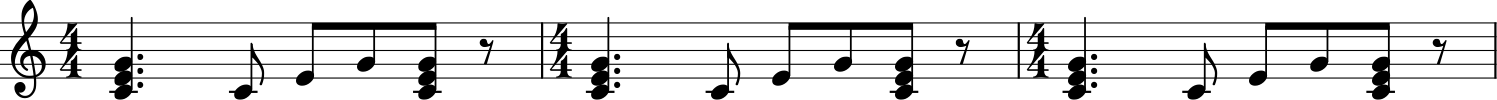

In [8]:
clean_score(s).show()

In [111]:
parse_note_data(clean_score(s).parts[0])

0.0 <music21.chord.Chord C4 E4 G4> (1.0, '0+', 4)
0.0 <music21.chord.Chord C4 E4 G4> (1.0, '4+', 4)
0.0 <music21.chord.Chord C4 E4 G4> [1.0, '7', 4]
1.5 <music21.chord.Chord C4> [0.125, '0', 4]
2.0 <music21.chord.Chord E4> [0.5, '4', 4]
2.5 <music21.chord.Chord G4> [0.125, '7', 4]
3.0 <music21.chord.Chord C4 E4 G4> (0.25, '0+', 4)
3.0 <music21.chord.Chord C4 E4 G4> (0.25, '4+', 4)
3.0 <music21.chord.Chord C4 E4 G4> [0.25, '7', 4]
3.5 <music21.note.Rest rest> (0.125, '-1', 4)
4.0 <music21.chord.Chord C4 E4 G4> (1.0, '0+', 4)
4.0 <music21.chord.Chord C4 E4 G4> (1.0, '4+', 4)
4.0 <music21.chord.Chord C4 E4 G4> [1.0, '7', 4]
5.5 <music21.chord.Chord C4> [0.125, '0', 4]
6.0 <music21.chord.Chord E4> [0.5, '4', 4]
6.5 <music21.chord.Chord G4> [0.125, '7', 4]
7.0 <music21.chord.Chord C4 E4 G4> (0.25, '0+', 4)
7.0 <music21.chord.Chord C4 E4 G4> (0.25, '4+', 4)
7.0 <music21.chord.Chord C4 E4 G4> [0.25, '7', 4]
7.5 <music21.note.Rest rest> (0.125, '-1', 4)
8.0 <music21.chord.Chord C4 E4 G4> (1.0,

[(1.0, '0+', 4),
 (1.0, '4+', 4),
 [1.0, '7', 4],
 [0.125, '0', 4],
 [0.5, '4', 4],
 [0.125, '7', 4],
 (0.25, '0+', 4),
 (0.25, '4+', 4),
 [0.25, '7', 4],
 (0.125, '-1', 4),
 (1.0, '0+', 4),
 (1.0, '4+', 4),
 [1.0, '7', 4],
 [0.125, '0', 4],
 [0.5, '4', 4],
 [0.125, '7', 4],
 (0.25, '0+', 4),
 (0.25, '4+', 4),
 [0.25, '7', 4],
 (0.125, '-1', 4),
 (1.0, '0+', 4),
 (1.0, '4+', 4),
 [1.0, '7', 4],
 [0.125, '0', 4],
 [0.5, '4', 4],
 [0.125, '7', 4],
 (0.25, '0+', 4),
 (0.25, '4+', 4),
 [0.25, '7', 4],
 (0.125, '-1', 4)]

In [103]:
cs1 = clean_score(s1)
cs1.parts.show('text')

{0.0} <music21.stream.Part Horn 2>
    {0.0} <music21.instrument.Instrument P1: Horn 2: Instrument 7>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.layout.PageLayout>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of C major>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Rest rest>
        {3.0} <music21.chord.Chord C4>
    {4.0} <music21.stream.Measure 1 offset=4.0>
        {0.0} <music21.chord.Chord D4>
        {0.5} <music21.chord.Chord G3>
        {1.0} <music21.chord.Chord C4>
        {1.5} <music21.chord.Chord C3>
        {2.0} <music21.chord.Chord E3>
        {2.5} <music21.chord.Chord C3>
        {3.0} <music21.chord.Chord E3>
        {3.5} <music21.chord.Chord G3>
    {8.0} <music21.stream.Measure 2 offset=8.0>
        {0.0} <music21.chord.Chord C4>
        {0.25} <music21.chord.Chord F4>
        {0.5} <music21.chord.Chord E4>
        {0.75} <music21.chord.Chord D4>
        {1.0} <music21.chord.Chor

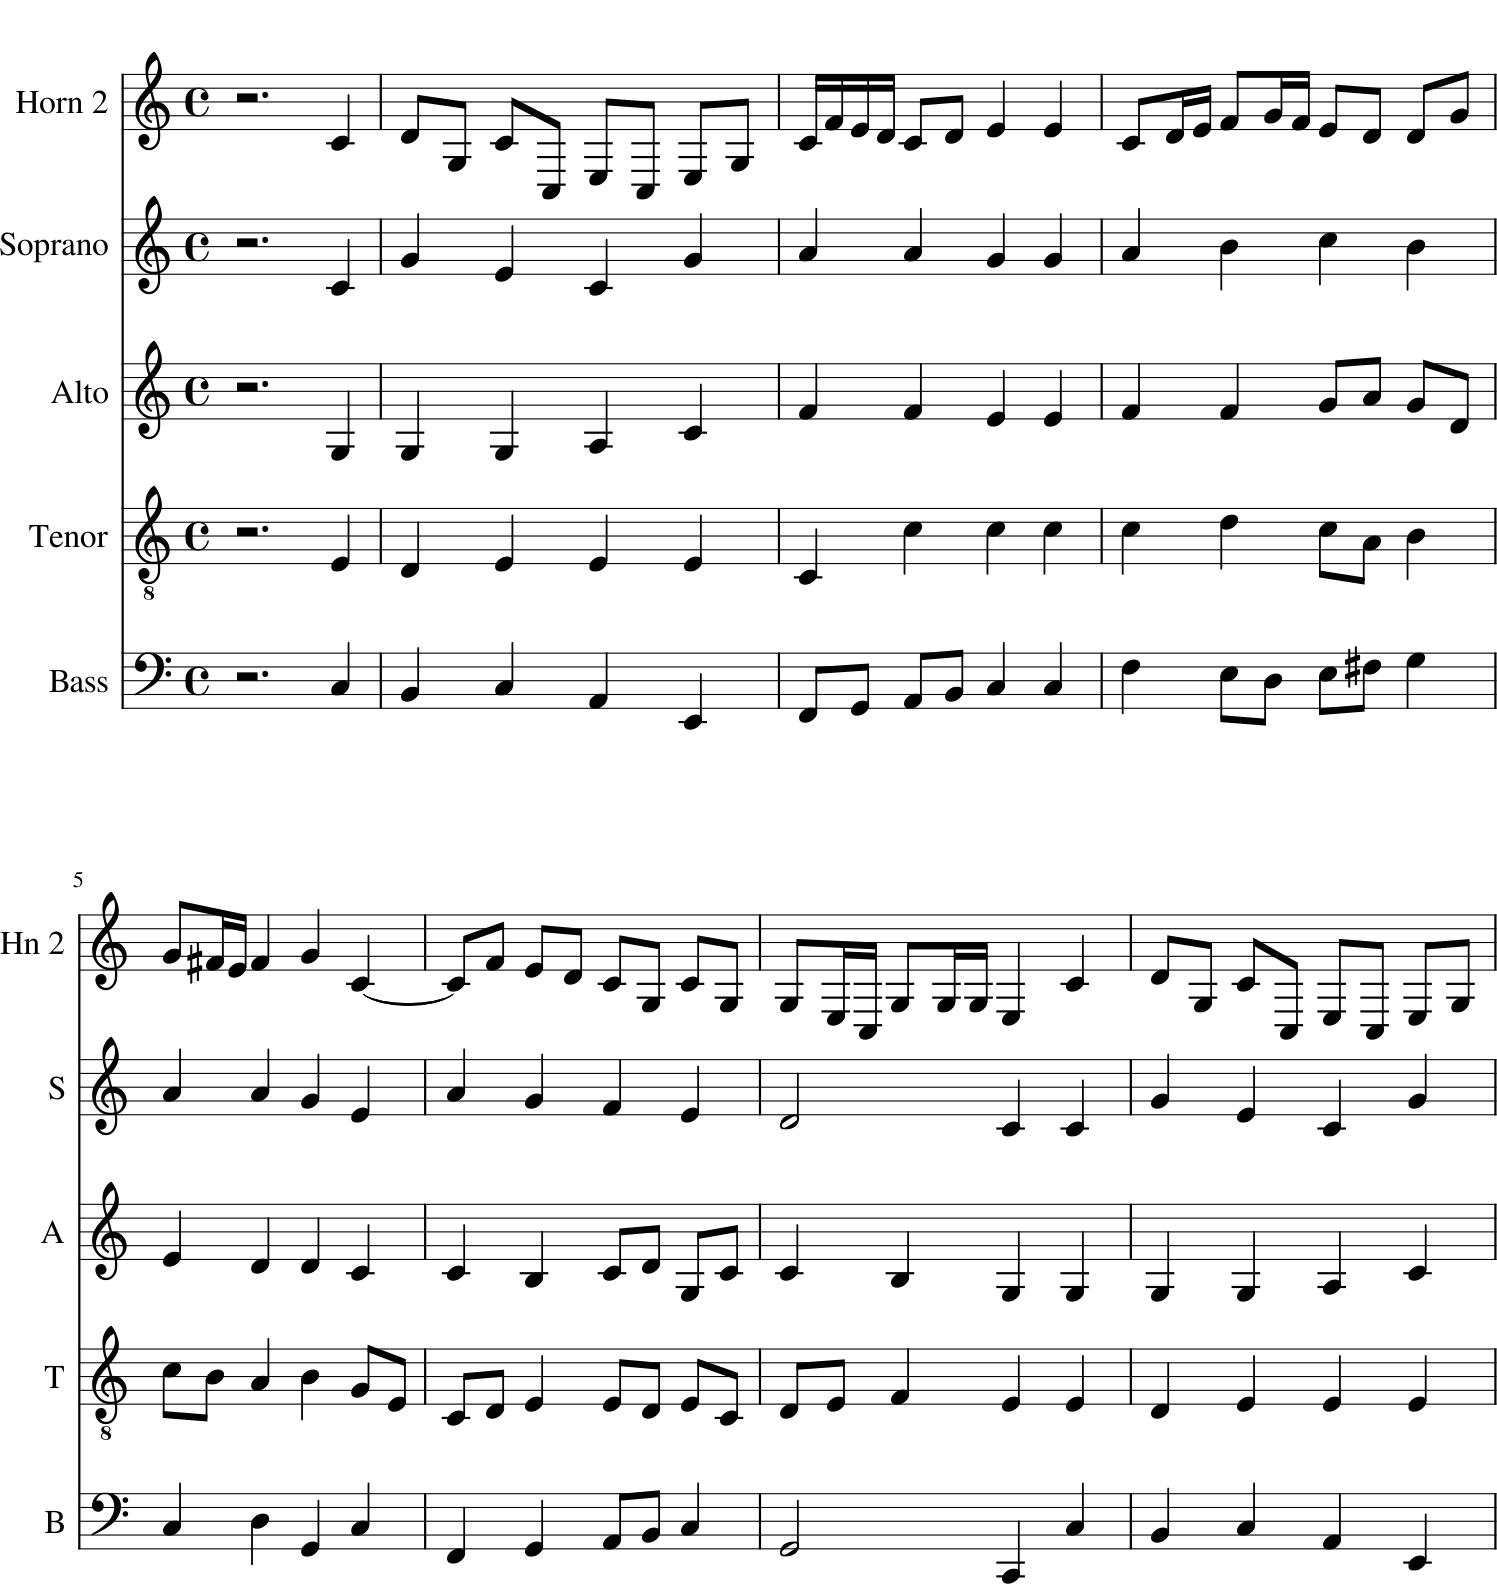

In [105]:
cs1.show()

In [6]:
s2 = clean_score(deepcopy(s1))

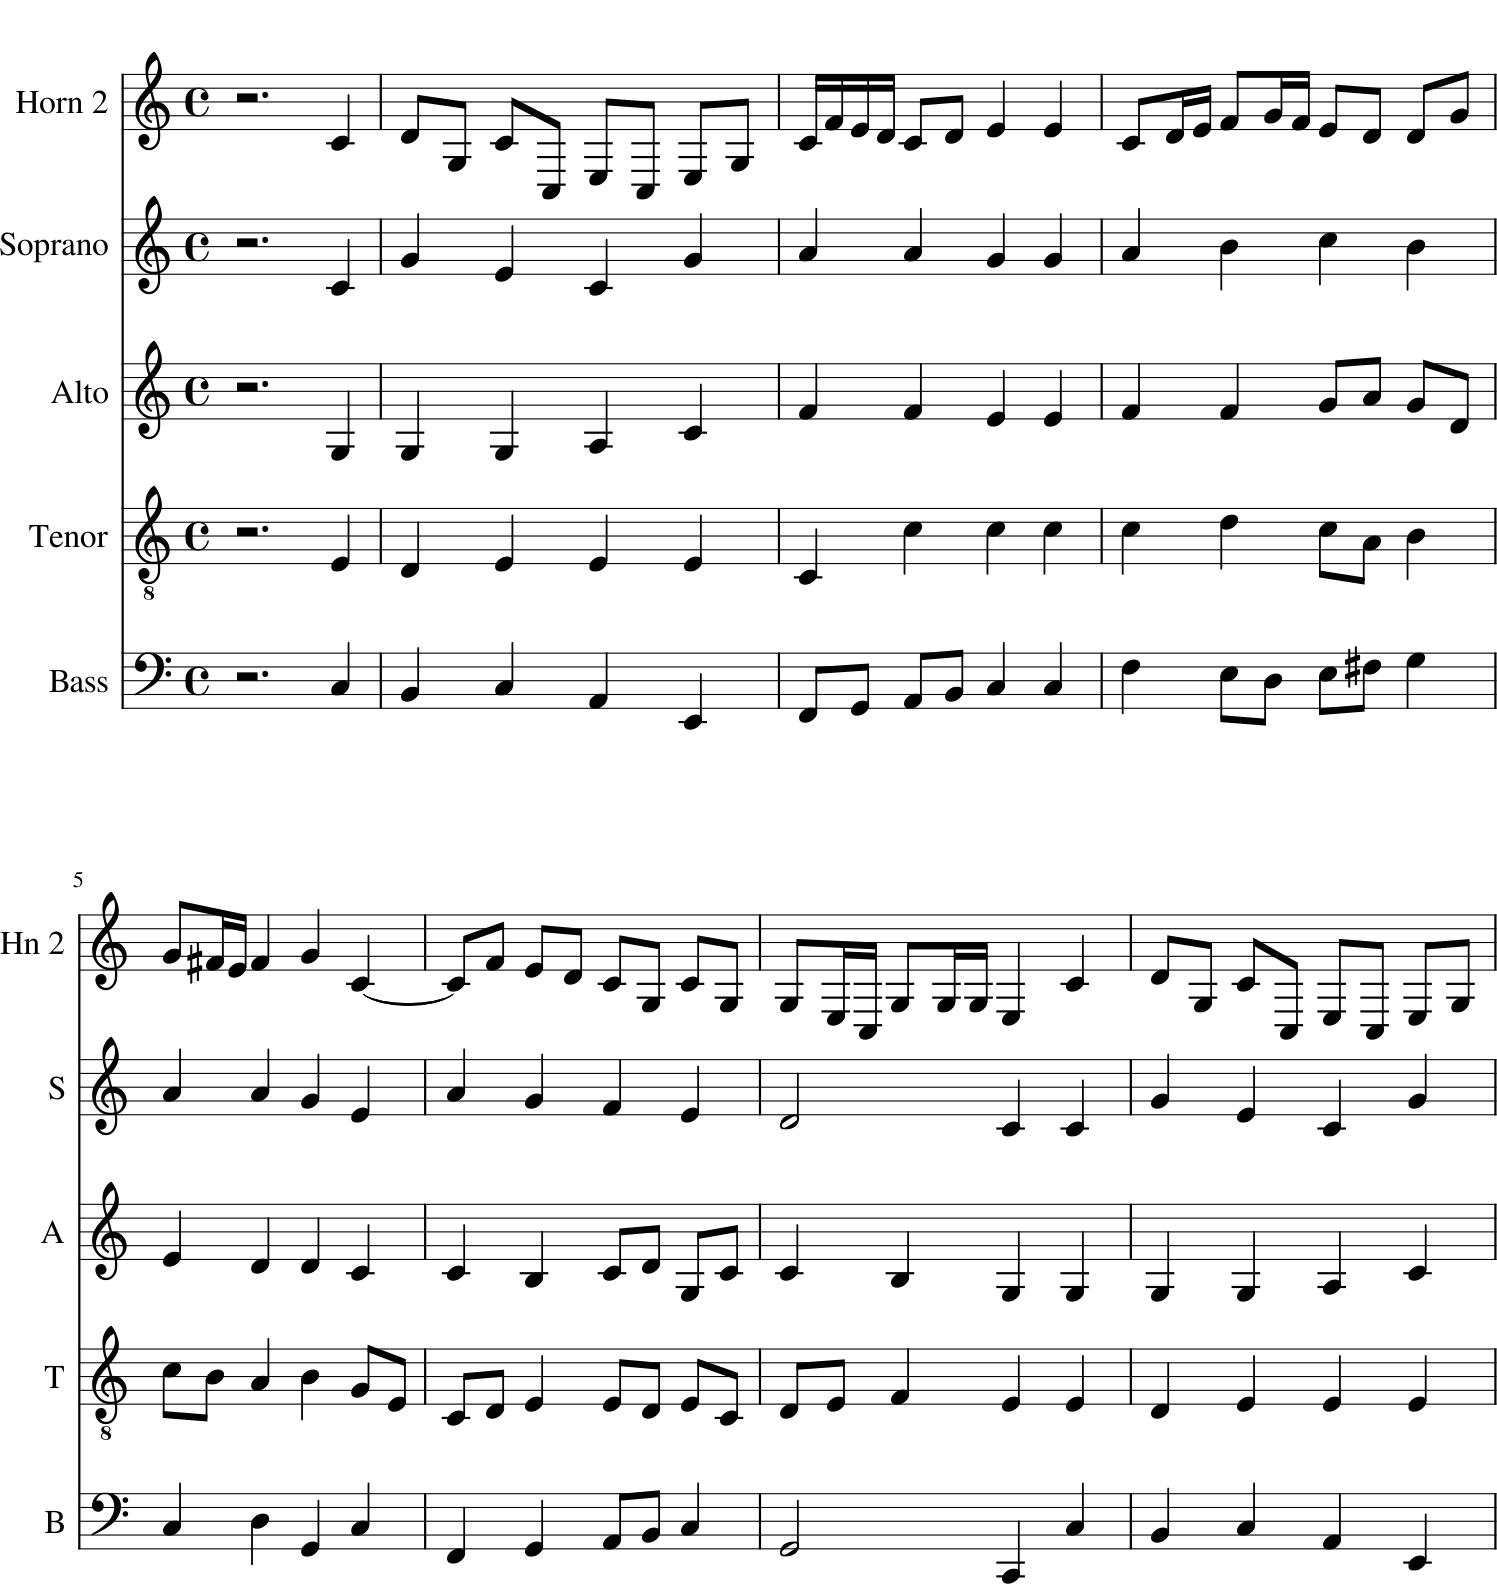

In [7]:
s2.show()

In [6]:
def rhythm_word(score, ts=None):
    '''
    Splits the score into single beat length 'words' that contain offset and tie information from that beat.
    - Includes START token with Time Signature information
    - Gets the length of the beat from the Time Signature
    - Robust against odd time signatures and tied notes
    - Weird results when time signature changes!
    '''
    
    data = []
    
    if not ts:
        try:
            ts = score.recurse().getElementsByClass("TimeSignature")[0]
        except:
            ts = m21.meter.TimeSignature('4/4')
    
    beat_length = Fraction(ts.beatDuration.quarterLength)
    
    for i in np.arange(score.duration.quarterLength, step=beat_length):
        w = score.flat.getElementsByOffset(i, i+beat_length, includeEndBoundary=False)
        word = []
        for x in w.flat.notesAndRests:
            if x.tie:
                if x.tie.type != 'start':
                    continue
    
            word.append(x.offset - i)
    
        data.append(word)
    
    return data

In [7]:
def rhythm_word2(score, force_ts=None):
    '''
    Splits the score into single beat length 'words' that contain offset and tie information from that beat.
    - Includes START token with Time Signature information
    - Gets the length of the beat from the Time Signature
    - Robust against odd time signatures and tied notes
    '''
    
    data = []
    
    if force_ts:
        ts = force_ts
    else:
        ts = m21.meter.TimeSignature('4/4')
    
    beat_length = Fraction(ts.beatDuration.quarterLength)
    
    for m in score.getElementsByClass("Measure"):
        if m.timeSignature and not force_ts:
            ts = m.timeSignature
            beat_length = Fraction(ts.beatDuration.quarterLength)
            print('New ts: ', ts, beat_length)
            
        off = m.offset
            
        for i in np.arange(m.duration.quarterLength, step=beat_length):
            w = m.flat.getElementsByOffset(i, i+beat_length, includeEndBoundary=False)
            word = []
            for x in w.flat.notesAndRests:
                if x.tie:
                    if x.tie.type != 'start':
                        continue

                word.append(x.offset - i)

            data.append(word)  
    
    return data

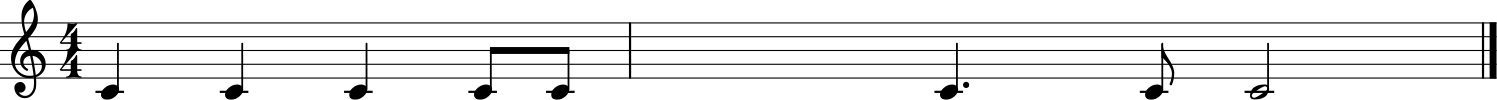

In [42]:
test_score = m21.stream.Score()
p1 = m21.stream.Part()
p1.append(m21.note.Note('c', quarterLength=1.0))
p1.append(m21.note.Note('c', quarterLength=1.0))
p1.append(m21.note.Note('c', quarterLength=1.0))
p1.append(m21.note.Note('c', quarterLength=0.5))
p1.append(m21.note.Note('c', quarterLength=0.5))
p1.append(m21.note.Note('c', quarterLength=1.5))
p1.append(m21.note.Note('c', quarterLength=0.5))
p1.append(m21.note.Note('c', quarterLength=2.0))

test_score.insert(0, p1)
test_score.makeMeasures(inPlace=True)
test_score.makeNotation(inPlace=True)
test_score.show()

In [53]:
for m in test_score.getElementsByClass("Measure"):
    print(m, m.barDuration, m.timeSignature)

<music21.stream.Measure 1 offset=0.0> <music21.duration.Duration 4.0> <music21.meter.TimeSignature 4/4>
<music21.stream.Measure 2 offset=4.0> <music21.duration.Duration 4.0> None


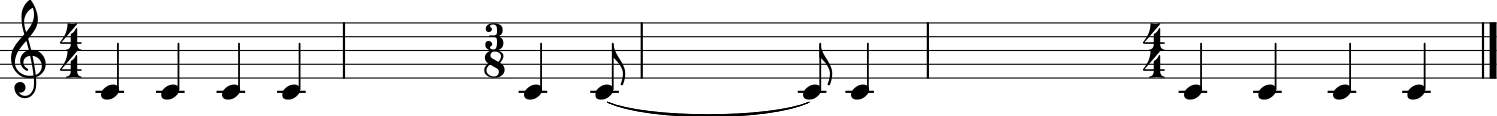

In [69]:
test_score2 = m21.stream.Score()
p2 = m21.stream.Part()
m1 = m21.stream.Measure()
m1.append(m21.meter.TimeSignature('4/4'))
m1.repeatAppend(m21.note.Note('c', quarterLength=1.0), 4)
m2 = m21.stream.Measure()
m2.append(m21.meter.TimeSignature('3/8'))
m2.repeatAppend(m21.note.Note('c', quarterLength=1.0), 3)
p2.append(m1)
p2.append(m2)
p2.append(deepcopy(m1))

test_score2.insert(0, p2)
test_score2.makeMeasures(inPlace=True)
test_score2.makeNotation(inPlace=True)
test_score2.show()

In [71]:
rhythm_word2(test_score2)

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [],
 [0.0],
 [0.0],
 [],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0]]

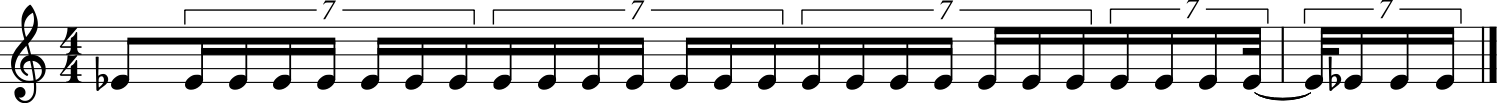

In [12]:
t = m21.duration.Tuplet(7, 4)
t.setDurationType('16th')
d = m21.duration.Duration('16th')
d.appendTuplet(t)
n = m21.note.Note('E-4')
n.duration = d
s = m21.stream.Stream()
s.append(m21.meter.TimeSignature('4/4'))
s.append(m21.note.Note('E-4', quarterLength=0.5))
s.repeatAppend(n, 28)
s.show()

In [13]:
for w in rhythm_word(s):
    print(w)

[0.0, 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14)]


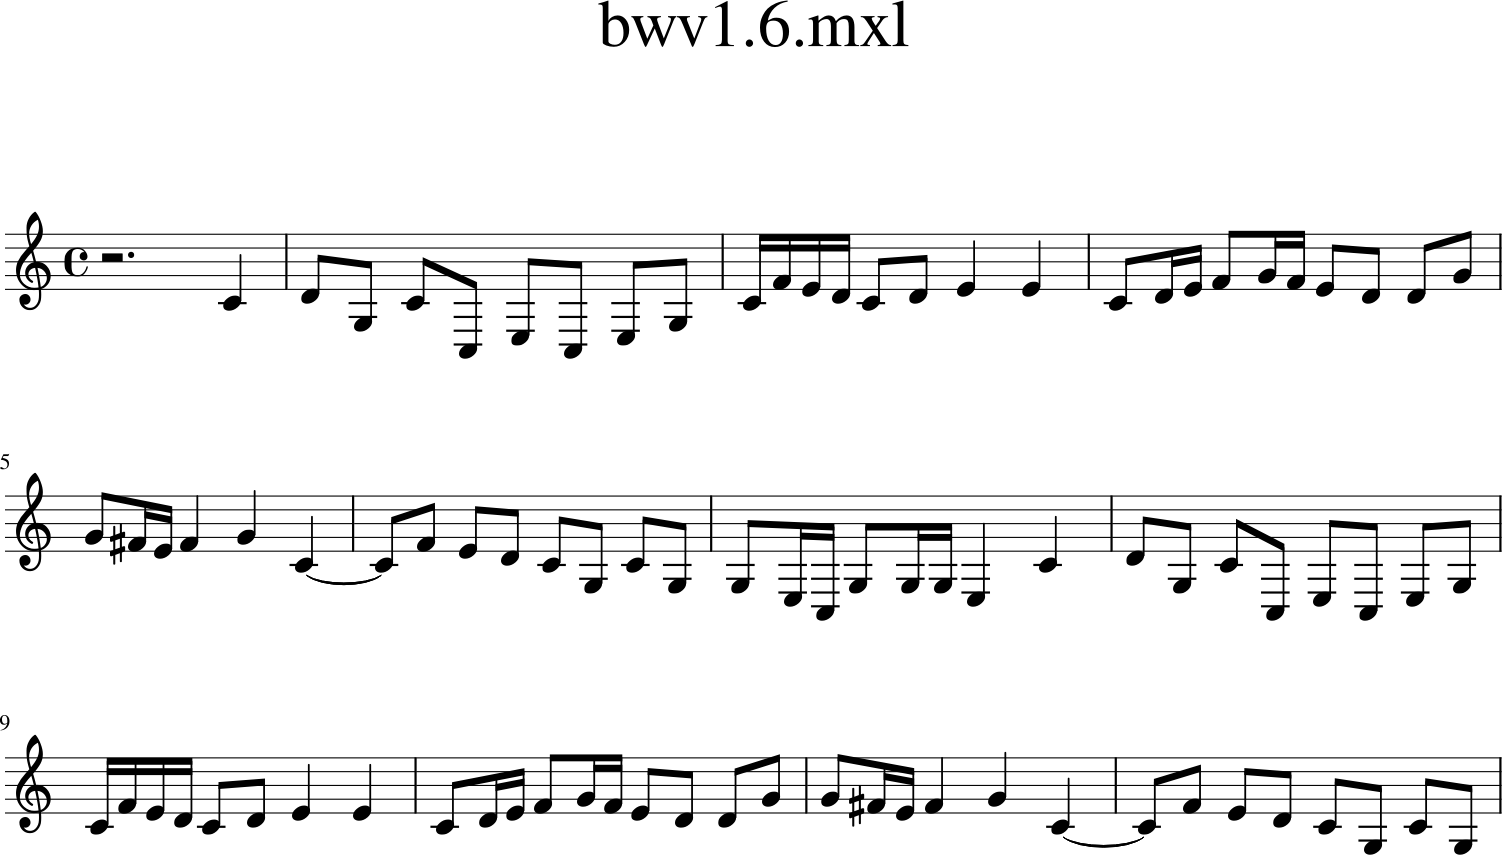

In [14]:
s2.parts[0].show()

In [15]:
words = rhythm_word(s2.parts[0])
print(words)
print(len(words))
print(s2.parts[0].duration)

[[0.0], [], [], [0.0], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.25, 0.5, 0.75], [0.0, 0.5], [0.0], [0.0], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0], [0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.25, 0.5, 0.75], [0.0, 0.5], [0.0], [0.0], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0], [0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0, 0.5, 0.75], [0.0, 0.25, 0.5, 0.75], [0.0], [], [0.0, 0.25, 0.5, 0.75], [0.0], [0.0], [], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0, 0.5], [0.0, 0.5], [0.0], [0.5], [0.0, 0.5, 0.75], [0.0], [0.5], [0.0, 0.5, 0.75], [0.0], [], [0.0, 0.25, 0.5, 0.75], [0.0], [0.5], [0.5], [0.5], [0.5], [0.5], [0.0, 0.5, 0.75], [0.0]]
83
<music21.duration.Duration 83.0>


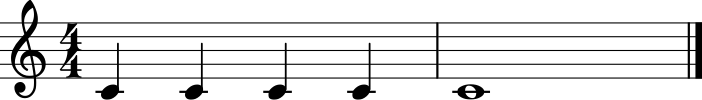

In [16]:
s3 = m21.stream.Stream()
s3.repeatAppend(m21.note.Note('C4', quarterLength=1.0), 4)
s3.append(m21.note.Note('C4', quarterLength=4.0))
s3.show()
# s3.show('midi')

In [17]:
rhythm_word(s3)

[[0.0], [0.0], [0.0], [0.0], [0.0], [], [], []]

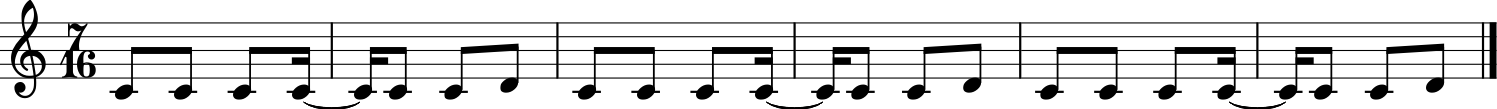

In [18]:
s4 = m21.stream.Stream()
ts = m21.meter.TimeSignature('7/16')
s4.insert(0.0, ts)
m4 = m21.stream.Measure()
n = m21.note.Note('C4', quarterLength=0.5)
m4.repeatAppend(n, 6)
m4.append(m21.note.Note('D4', quarterLength=0.5))
s4.repeatAppend(m4, 3)
s4.makeMeasures(inPlace=True)
s4.makeNotation(inPlace=True)
s4.show()

In [19]:
s4.highestOffset

8.75

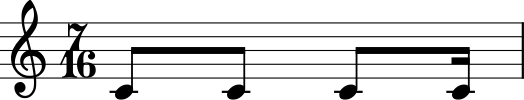

<music21.duration.Duration 1.75>
1 : 7/16
[[0.0], [], [0.0], [], [0.0], [], [0.0]]
[(1.0, '0', 4), (0.5, '0', 4), (0.5, '0', 4), (0.5, '0', 4)]


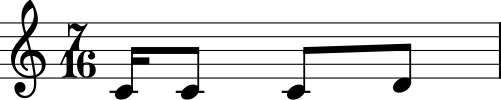

<music21.duration.Duration 1.75>
2 : 7/16
[[], [0.0], [], [0.0], [], [0.0], []]
[(0.5, '0', 4), (0.5, '0', 4), (0.5, '2', 4)]


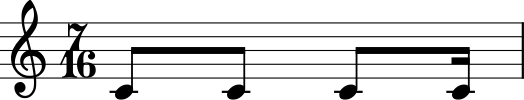

<music21.duration.Duration 1.75>
3 : 7/16
[[0.0], [], [0.0], [], [0.0], [], [0.0]]
[(1.0, '0', 4), (0.5, '0', 4), (0.5, '0', 4), (0.5, '0', 4)]


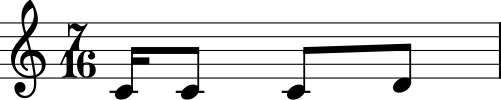

<music21.duration.Duration 1.75>
4 : 7/16
[[], [0.0], [], [0.0], [], [0.0], []]
[(0.5, '0', 4), (0.5, '0', 4), (0.5, '2', 4)]


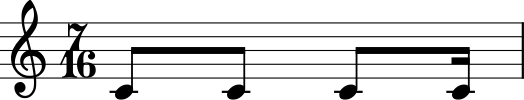

<music21.duration.Duration 1.75>
5 : 7/16
[[0.0], [], [0.0], [], [0.0], [], [0.0]]
[(1.0, '0', 4), (0.5, '0', 4), (0.5, '0', 4), (0.5, '0', 4)]


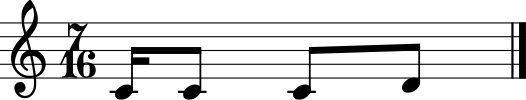

<music21.duration.Duration 1.75>
6 : 7/16
[[], [0.0], [], [0.0], [], [0.0], []]
[(0.5, '0', 4), (0.5, '0', 4), (0.5, '2', 4)]


In [20]:
last_ts = None
for m in s4.getElementsByClass('Measure'):
    m.show()
    print(m.duration)
    ts = m.timeSignature
    if not ts:
        ts = last_ts
    else:
        last_ts = ts
    print(m.number, ":", ts.ratioString)
    notes = parse_note_data(m, ts=ts)
    rhythms = rhythm_word(m, ts=ts)
    print(rhythms)
    print(notes)

In [4]:
def construct_rhythm(beats, ts=None):
    '''
    Converts a set of beats into measures
    '''
    if not ts:
        ts = m21.meter.TimeSignature('4/4')
        
    score = m21.stream.Score()
    score.insert(0.0, ts)
    
    offset = 0
    print(beats)
    beat_length = ts.beatDuration.quarterLength
    for i, beat in enumerate(beats):
        for b in beat:
            os = (i*beat_length)+b
            try:
                last_note = score.notes[-1]
                duration = os - last_note.offset
                last_note.quarterLength = duration
            except:
                pass
            score.insert(os, m21.note.Note('C4'))
    
#     try:
#         last_note = score.notes[-1]
#         duration = ts.numerator - last_note.beat + beat_length
#         print(duration, ts.numerator, last_note.beat, beat_length)
#         last_note.quarterLength = duration
#     except:
#         pass
        
    score.makeMeasures(inPlace=True)
    score.makeNotation(inPlace=True)
    return score

In [5]:
def get_strengths(beats, ts=None):
    '''
    Returns the strengths of the beats as a list for MELODY networks
    '''
    if not ts:
        ts = m21.meter.TimeSignature('4/4')
    beat_length = ts.beatDuration.quarterLength
    strengths = []
    for i, beat in enumerate(beats):
        for b in beat:
            os = (i*beat_length)+b
            strengths.append(ts.getAccentWeight(os, permitMeterModulus=True))
    return strengths

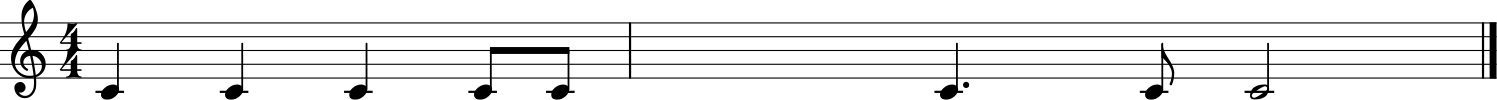

[[0.0], [0.0], [0.0], [0.0, 0.5], [0.0], [0.5], [0.0], []]


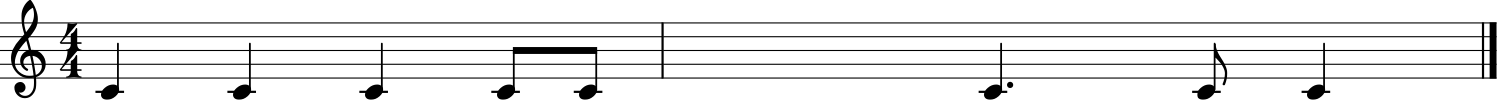

[1.0, 0.25, 0.5, 0.25, 0.125, 1.0, 0.125, 0.5]


In [23]:
test_score.show()
# test_score.show('text')
cons = construct_rhythm(rhythm_word(test_score))
cons.show()
# cons.show('text')
print(get_strengths(rhythm_word(test_score)))

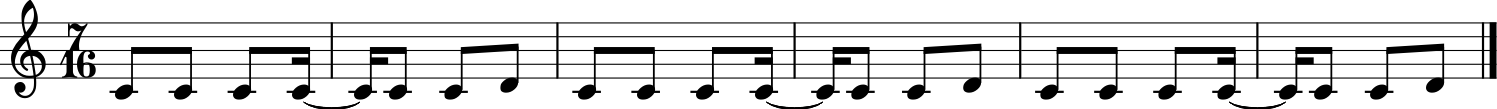

[[0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], []]


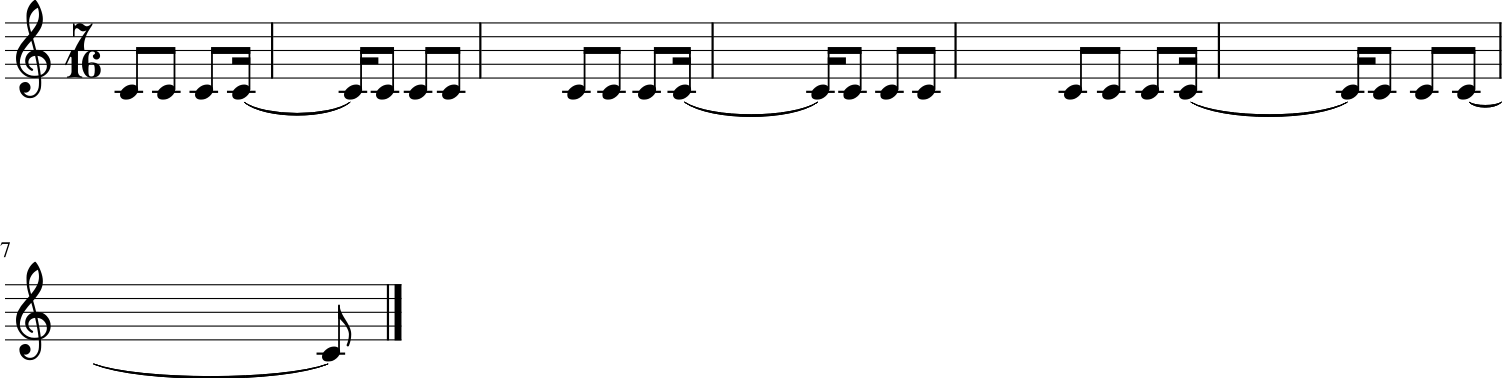

[1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [24]:
s4.show()
# test_score.show('text')
cons4 = construct_rhythm(rhythm_word(s4), ts=m21.meter.TimeSignature('7/16'))
cons4.show()
# cons.show('text')
print(get_strengths(rhythm_word(s4), ts=m21.meter.TimeSignature('7/16')))

In [8]:
ledZep = m21.converter.parseFile("/home/arran/projects/guitarPro/LedZep3.mxl")

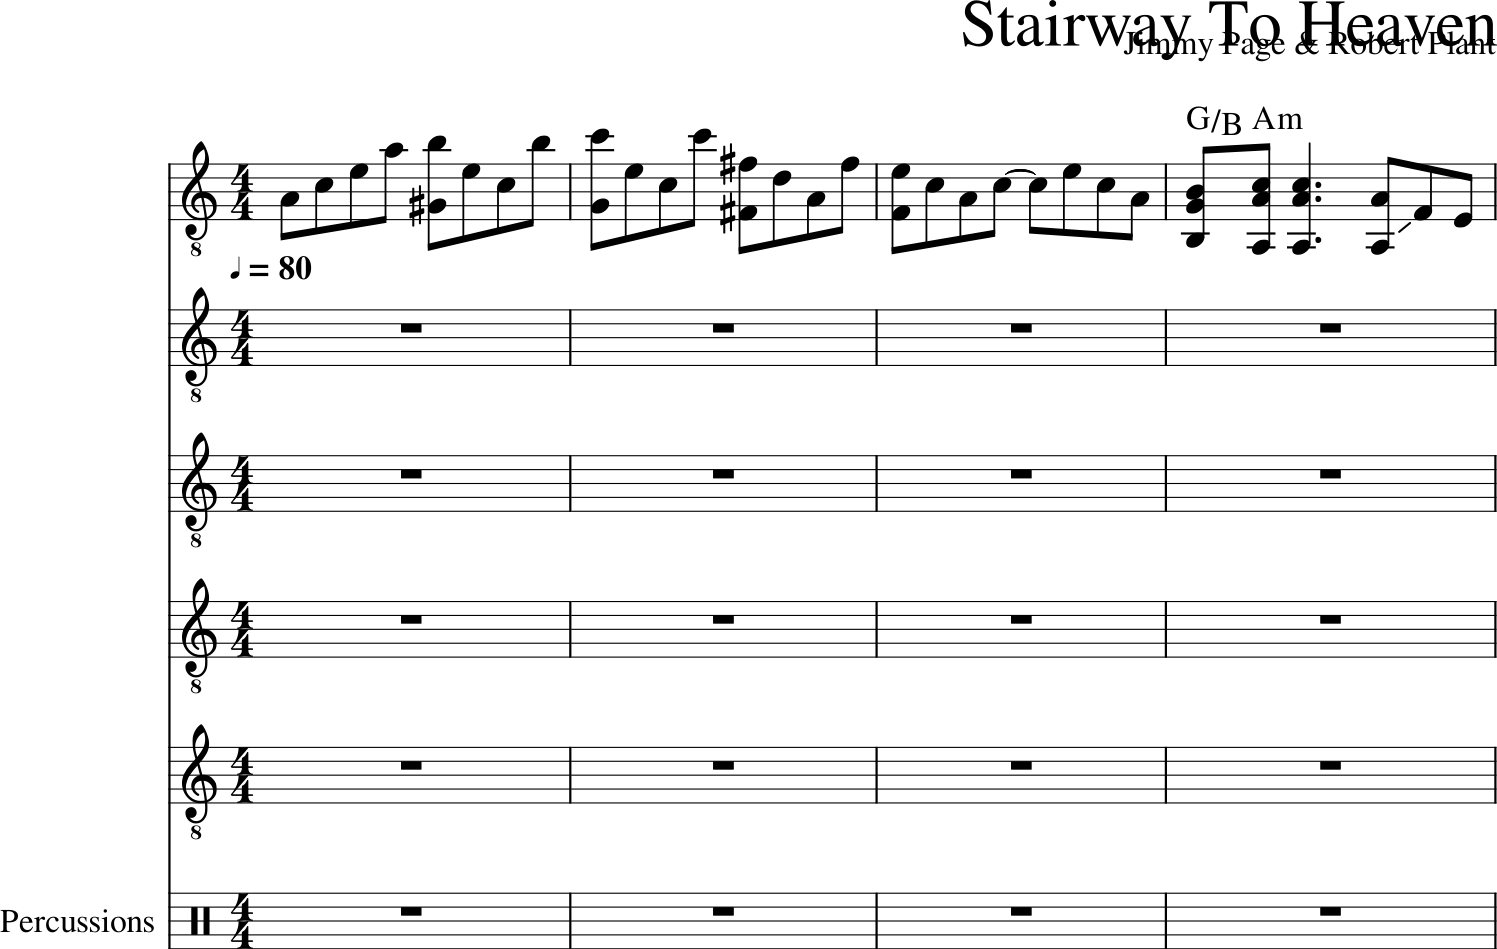

In [8]:
ledZep.show()

In [40]:
ledZep.show('midi')

In [35]:
for p in ledZep.parts:
    m = p.getElementsByClass("Measure")[3]
    print(m, m.clef, m.timeSignature)
    m.show('text')

<music21.stream.Measure 4 offset=12.0> None None
{0.0} <music21.harmony.ChordSymbol G/B>
{0.0} <music21.chord.Chord B2 G3 B3>
{0.5} <music21.harmony.ChordSymbol Am>
{0.5} <music21.chord.Chord A2 A3 C4>
{1.0} <music21.chord.Chord A2 A3 C4>
{2.5} <music21.chord.Chord A2 A3>
{3.0} <music21.note.Note F>
{3.5} <music21.note.Note E>
<music21.stream.Measure 4 offset=12.0> None None
{0.0} <music21.note.Rest rest>
<music21.stream.Measure 4 offset=12.0> None None
{0.0} <music21.note.Rest rest>
<music21.stream.Measure 4 offset=12.0> None None
{0.0} <music21.note.Rest rest>
<music21.stream.Measure 4 offset=12.0> None None
{0.0} <music21.note.Rest rest>
<music21.stream.Measure 4 offset=12.0> None None
{0.0} <music21.note.Rest rest>


In [9]:
ledZep.parts[0].show('text')

{0.0} <music21.instrument.Instrument P1: >
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.layout.SystemLayout>
    {0.0} <music21.clef.Treble8vbClef>
    {0.0} <music21.tempo.MetronomeMark andantino Quarter=80.0>
    {0.0} <music21.key.KeySignature of no sharps or flats>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note A>
    {0.5} <music21.note.Note C>
    {1.0} <music21.note.Note E>
    {1.5} <music21.note.Note A>
    {2.0} <music21.chord.Chord G#3 B4>
    {2.5} <music21.note.Note E>
    {3.0} <music21.note.Note C>
    {3.5} <music21.note.Note B>
{0.0} <music21.spanner.Glissando <music21.chord.Chord A2 A3><music21.note.Note F>>
{0.0} <music21.spanner.Slur <music21.chord.Chord D3 G4><music21.note.Note F#>>
{0.0} <music21.spanner.Slur <music21.chord.Chord D3 G4><music21.note.Note F#>>
{0.0} <music21.spanner.Glissando <music21.note.Note A><music21.note.Note F>>
{0.0} <music21.spanner.Slur <music21.chord.Chord G3 D4><music21.note.Note A>>
{0.0} <mu

In [10]:
cLedZep = clean_score(ledZep)

Cleaning...
Found Key (a minor)...
<music21.stream.Part 0x7f45c412f208> ----------
padding  118
padding  119
padding  120
padding  121
padding  122
padding  123
padding  124
padding  125
padding  126
padding  127
padding  128
padding  129
padding  130
padding  131
padding  132
padding  133
padding  134
padding  135
padding  136
padding  137
padding  138
padding  139
padding  140
padding  141
padding  142
padding  143
padding  144
padding  145
padding  146
padding  147
padding  148
padding  149
padding  150
padding  151
padding  152
padding  153
padding  154
padding  155
padding  156
padding  157
padding  158
padding  159
padding  160
padding  161
padding  162
padding  163
padding  164
padding  165
padding  166
<music21.stream.Part 0x7f45c459fa90> ----------
<music21.stream.Part 0x7f45c4b1f940> ----------
padding  111
padding  113
padding  115
<music21.stream.Part 0x7f45c5e12668> ----------
padding  111
padding  113
padding  115
<music21.stream.Part 0x7f45c6039080> ----------
padding  1

In [11]:
rhythm_word2(cLedZep.parts[0])

New ts:  <music21.meter.TimeSignature 4/4> 1
New ts:  <music21.meter.TimeSignature 3/4> 1
New ts:  <music21.meter.TimeSignature 4/4> 1
New ts:  <music21.meter.TimeSignature 5/4> 1
New ts:  <music21.meter.TimeSignature 4/4> 1
New ts:  <music21.meter.TimeSignature 7/8> 1/2
New ts:  <music21.meter.TimeSignature 4/4> 1


[[0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.25, 0.5],
 [0.0],
 [],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [],
 [0.0],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [],
 [0.0],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [

In [88]:
parse_note_data(cLedZep.parts[0])

[(1.0, '0', 3),
 (0.125, '3', 3),
 (0.25, '7', 3),
 (0.125, '0', 4),
 (0.5, '11+', 2),
 (0.5, '2', 4),
 (0.125, '7', 3),
 (0.25, '3', 3),
 (0.125, '2', 4),
 (1.0, '10+', 2),
 (1.0, '3', 4),
 (0.125, '7', 3),
 (0.25, '3', 3),
 (0.125, '3', 4),
 (0.5, '9+', 2),
 (0.5, '9', 3),
 (0.125, '5', 3),
 (0.25, '0', 3),
 (0.125, '9', 3),
 (1.0, '8+', 2),
 (1.0, '7', 3),
 (0.125, '3', 3),
 (0.25, '0', 3),
 (0.125, '3', 3),
 (0.125, '7', 3),
 (0.25, '3', 3),
 (0.125, '0', 3),
 (1.0, '2+', 2),
 (1.0, '5+', 2),
 (1.0, '10+', 2),
 (1.0, '2', 3),
 (0.125, '0+', 2),
 (0.125, '3+', 2),
 (0.125, '7+', 2),
 (0.125, '0+', 3),
 (0.125, '3', 3),
 (0.25, '0+', 2),
 (0.25, '0+', 3),
 (0.25, '3', 3),
 (0.125, '0+', 2),
 (0.125, '0', 3),
 (0.25, '8', 2),
 (0.125, '7', 2),
 (1.0, '0', 2),
 (0.125, '0', 3),
 (0.25, '3', 3),
 (0.125, '7', 3),
 (0.5, '2+', 2),
 (0.5, '7+', 2),
 (0.5, '11+', 2),
 (0.5, '2', 4),
 (0.125, '7', 3),
 (0.25, '3', 3),
 (0.125, '2', 4),
 (1.0, '10+', 1),
 (1.0, '3+', 2),
 (1.0, '7+', 2),
 (1

In [67]:
ws = m21.converter.parse('/home/arran/projects/guitarPro/WS.mxl')

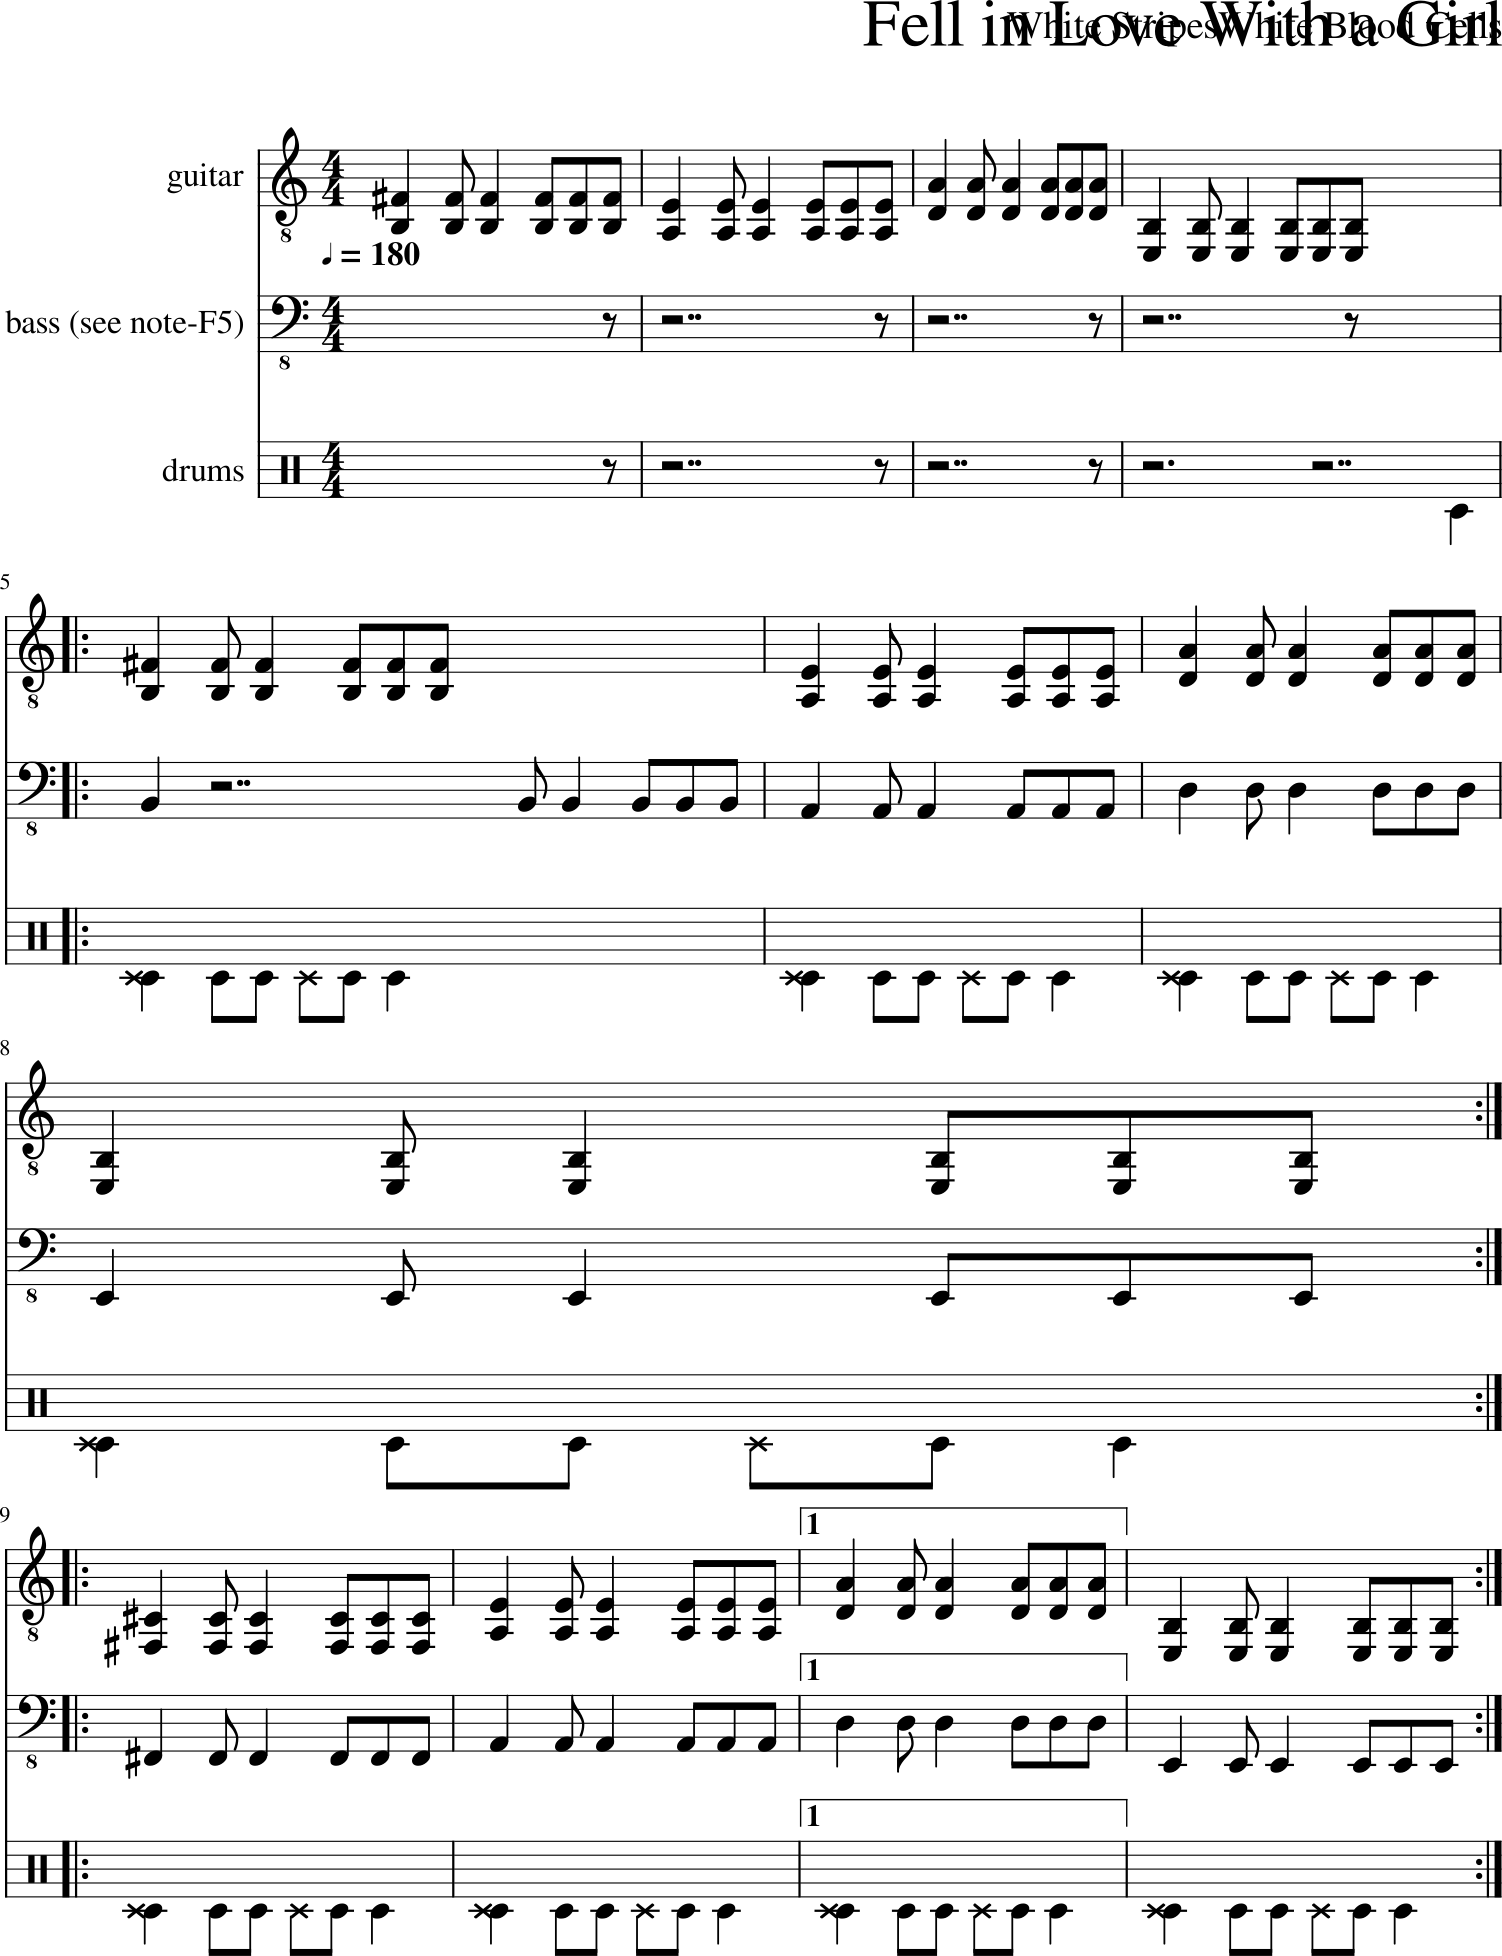

In [68]:
ws.show()

In [63]:
ws.parts[1].show('text')

{0.0} <music21.instrument.Instrument P2: bass (see note-F5): >
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.layout.SystemLayout>
    {0.0} <music21.layout.StaffLayout distance 0, staffNumber 1, staffSize None, staffLines None>
    {0.0} <music21.clef.Bass8vbClef>
    {0.0} <music21.key.KeySignature of no sharps or flats>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest rest>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 11 offset=0.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 13 offset=0.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 21 offset=0.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 23 offset=0.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 31 offset=0.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 33 offset=0.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 41 offset=0.0>>
{0.0} <music21.spanner.Repe

In [113]:
cWS = clean_score(ws, verbose=True)

Cleaning...
Found Key (a minor)...
<music21.stream.Part guitar> ----------
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
<music21.stream.Part bass (see note-F5)> ----------
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
<music21.stream.Part drums> ----------
Percussion, skipping!


In [90]:
for m in ws.parts[1].getElementsByClass("Measure"):
    # check if measure only contains rests...
#     if len(m.notesAndRests) == len(m.getElementsByClass(m21.note.Rest)):
#         print('only rests')
#     else:
#         print('contains notes too')
    
    
    print(m.number, m.duration, m.barDuration)
    for n in m.notesAndRests:
        print(n, n.offset, n.duration)

1 <music21.duration.Duration 7.5> <music21.duration.Duration 4.0>
<music21.note.Rest rest> 3.5 <music21.duration.Duration 4.0>
2 <music21.duration.Duration 7.5> <music21.duration.Duration 4.0>
<music21.note.Rest rest> 3.5 <music21.duration.Duration 4.0>
3 <music21.duration.Duration 7.5> <music21.duration.Duration 4.0>
<music21.note.Rest rest> 3.5 <music21.duration.Duration 4.0>
4 <music21.duration.Duration 7.5> <music21.duration.Duration 4.0>
<music21.note.Rest rest> 3.5 <music21.duration.Duration 4.0>
5 <music21.duration.Duration 4.0> <music21.duration.Duration 4.0>
<music21.note.Note B> 0.0 <music21.duration.Duration 1.0>
<music21.note.Note B> 1.0 <music21.duration.Duration 0.5>
<music21.note.Note B> 1.5 <music21.duration.Duration 1.0>
<music21.note.Note B> 2.5 <music21.duration.Duration 0.5>
<music21.note.Note B> 3.0 <music21.duration.Duration 0.5>
<music21.note.Note B> 3.5 <music21.duration.Duration 0.5>
6 <music21.duration.Duration 4.0> <music21.duration.Duration 4.0>
<music21.not

<music21.note.Note B> 0.0 <music21.duration.Duration 1.0>
<music21.note.Note B> 1.0 <music21.duration.Duration 0.5>
<music21.note.Note B> 1.5 <music21.duration.Duration 1.0>
<music21.note.Note B> 2.5 <music21.duration.Duration 0.5>
<music21.note.Note B> 3.0 <music21.duration.Duration 0.5>
<music21.note.Note B> 3.5 <music21.duration.Duration 0.5>
36 <music21.duration.Duration 4.0> <music21.duration.Duration 4.0>
<music21.note.Note A> 0.0 <music21.duration.Duration 1.0>
<music21.note.Note A> 1.0 <music21.duration.Duration 0.5>
<music21.note.Note A> 1.5 <music21.duration.Duration 1.0>
<music21.note.Note A> 2.5 <music21.duration.Duration 0.5>
<music21.note.Note A> 3.0 <music21.duration.Duration 0.5>
<music21.note.Note A> 3.5 <music21.duration.Duration 0.5>
37 <music21.duration.Duration 4.0> <music21.duration.Duration 4.0>
<music21.note.Note D> 0.0 <music21.duration.Duration 1.0>
<music21.note.Note D> 1.0 <music21.duration.Duration 0.5>
<music21.note.Note D> 1.5 <music21.duration.Duration 1

In [117]:
cWS.parts[1].show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.clef.Bass8vbClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest rest>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord D1>
    {1.0} <music21.chord.Chord D1>
    {1.5} <music21.chord.Chord D1>
    {2.5} <music21.chord.Chord D1>
    {3.0} <music21.chord.Chord D1>
    {3.5} <music21.chord.Chord D1>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.chord.Chord C1>
    {1.0} <music21.chord.Chord C1>
    {1.5} <music21.chord.Chord C1>
    {2.5} <music21.chord.Chord C1>
    {3.0} <music21.chord.Chord C1>
    {3.5} <music21.chord.Chord C1>
{12.0} <music21.stream.Measure 4 offset=12.0>
    {0.0} <music21.chord.Chord F1>
    {1.0} <music21.chord.Chord F1>
    {1.5} <music21.chord.Chord F1>
    {2.5} <music21.chord.Chord F1>
    {3.0} <music21.chord.Chord F1>
    {3.5} <music21.chord.Chord F1>
{16.0} <music21.stream.Measure 5 offset=16.0>
    {0.0} <music21.chord.Chord

In [107]:
ws.parts[1].show('text')

{0.0} <music21.instrument.Instrument P2: bass (see note-F5): >
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.layout.SystemLayout>
    {0.0} <music21.layout.StaffLayout distance 0, staffNumber 1, staffSize None, staffLines None>
    {0.0} <music21.clef.Bass8vbClef>
    {0.0} <music21.key.KeySignature of no sharps or flats>
    {0.0} <music21.meter.TimeSignature 4/4>
    {3.5} <music21.note.Rest rest>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 11 offset=54.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 13 offset=62.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 21 offset=94.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 23 offset=102.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 31 offset=134.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 33 offset=142.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 41 offset=174.0>>
{0.0} <music21.s

In [127]:
parse_note_data(cWS.parts[0])

[(1.0, 1.0, '2+', 2),
 (1.0, 1.0, '9', 2),
 (0.25, 0.5, '2+', 2),
 (0.25, 0.5, '9', 2),
 (0.125, 1.0, '2+', 2),
 (0.125, 1.0, '9', 2),
 (0.125, 0.5, '2+', 2),
 (0.125, 0.5, '9', 2),
 (0.25, 0.5, '2+', 2),
 (0.25, 0.5, '9', 2),
 (0.125, 0.5, '2+', 2),
 (0.125, 0.5, '9', 2),
 (1.0, 1.0, '0+', 2),
 (1.0, 1.0, '7', 2),
 (0.25, 0.5, '0+', 2),
 (0.25, 0.5, '7', 2),
 (0.125, 1.0, '0+', 2),
 (0.125, 1.0, '7', 2),
 (0.125, 0.5, '0+', 2),
 (0.125, 0.5, '7', 2),
 (0.25, 0.5, '0+', 2),
 (0.25, 0.5, '7', 2),
 (0.125, 0.5, '0+', 2),
 (0.125, 0.5, '7', 2),
 (1.0, 1.0, '5+', 2),
 (1.0, 1.0, '0', 3),
 (0.25, 0.5, '5+', 2),
 (0.25, 0.5, '0', 3),
 (0.125, 1.0, '5+', 2),
 (0.125, 1.0, '0', 3),
 (0.125, 0.5, '5+', 2),
 (0.125, 0.5, '0', 3),
 (0.25, 0.5, '5+', 2),
 (0.25, 0.5, '0', 3),
 (0.125, 0.5, '5+', 2),
 (0.125, 0.5, '0', 3),
 (1.0, 1.0, '7+', 1),
 (1.0, 1.0, '2', 2),
 (0.25, 0.5, '7+', 1),
 (0.25, 0.5, '2', 2),
 (0.125, 1.0, '7+', 1),
 (0.125, 1.0, '2', 2),
 (0.125, 0.5, '7+', 1),
 (0.125, 0.5, '2', 